In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:99% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:15pt;}
div.text_cell_render.rendered_html{font-size:18pt;}
div.text_cell_render ul li{font-size:22pt; line-height:30px;}
div.output {font-size:22pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:22pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:22pt;padding:5px;}
table.dataframe{font-size:22px;}
</style>
"""))

In [34]:
# ===============================
# 📌 기본 라이브러리
# ===============================
import pandas as pd
import numpy as np

# ===============================
# 📌 시각화 라이브러리
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
#  지도 시각화용 라이브러리 아나콘다에 설치.
#  아나콘다 프롬프트에서
#  conda install -c conda-forge geopandas 
# ===============================

import geopandas as gpd
from shapely.geometry import Point

gpd.__version__


# ===============================
# 📌 경고 메시지 제거 (대용량 CSV 처리 시 깔끔)
# ===============================
import warnings
warnings.filterwarnings("ignore")

# ===============================
# 📌 한글 폰트 설정 (Windows)
# ===============================
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# ===============================
# 📌 CSV에서 불러올 컬럼 지정
# (불필요한 컬럼 제거 → 메모리 절약)
# ===============================
use_cols = [
    '인허가일자',
    '상세영업상태명',
    '폐업일자',
    '소재지전체주소',
    '도로명전체주소',
    '업태구분명',
    '좌표정보x(epsg5174)',
    '좌표정보y(epsg5174)',
    '사업장명'
]


In [4]:
# ===============================
# 📌 데이터 로드
# ===============================
df = pd.read_csv(
    r"C:\ai\lecNote\1st_Project\data\6110000_서울특별시_07_24_04_P_일반음식점.csv",
    encoding="cp949",
    usecols=use_cols,
    low_memory=False
)

In [5]:
# 소재지 주소가 있으면 우선 사용, 없으면 도로명 주소 사용
df['주소'] = df['소재지전체주소'].fillna(df['도로명전체주소'])

In [6]:
df['주소'].isna().sum()

0

In [7]:
# 주소 문자열에서 '○○구' 패턴 추출
df['구'] = df['주소'].str.extract(r'(서울특별시\s*)?(\w+구)')[1]
# 구 정보 없는 행 제거
df[['주소', '구']].head()

,주소,구
0,서울특별시 강북구 수유동 229-46,강북구
1,서울특별시 종로구 관훈동 155-2,종로구
2,서울특별시 종로구 관훈동 155-2,종로구
3,서울특별시 종로구 인사동 241,종로구
4,서울특별시 양천구 신월동 60-33,양천구


In [8]:
# '구' 결측치 제거
df['구'].isna().sum()
df = df[df['구'].notna()].copy()

In [9]:
# 서울특별시 데이터만 유지 (타 지역 자동 제거)
df = df[df['주소'].str.contains('서울', na=False)].copy()

In [10]:
# 문자열 → datetime 변환
df['인허가일자'] = pd.to_datetime(df['인허가일자'], errors='coerce')
df['폐업일자'] = pd.to_datetime(df['폐업일자'], errors='coerce')

# 인허가일자 없는 행 제거
df = df[df['인허가일자'].notna()].copy()

# ✅ 기간 필터: 2000-02-01 ~ 2022-11-30 (둘 다 포함)
start = pd.Timestamp("2000-02-01")
end   = pd.Timestamp("2022-11-30")
df = df[df["인허가일자"].between(start, end, inclusive="both")].copy()

# 좌표 결측치 제거
df = df[
    df['좌표정보x(epsg5174)'].notna() &
    df['좌표정보y(epsg5174)'].notna()
].copy()

In [11]:
# 창업월, 창업연도
df['창업월'] = df['인허가일자'].dt.month
df['창업연도'] = df['인허가일자'].dt.year

In [12]:
# 영업 기간 계산 
df['영업일수'] = (
    df['폐업일자'].fillna(pd.Timestamp.today())
    - df['인허가일자']
).dt.days

In [13]:
#3년 이내 폐업 여부
df['폐업_3년이내'] = (
    (df['폐업일자'].notna()) &
    (df['영업일수'] <= 365 * 3)
).astype(int)

In [14]:
#문자열의 앞뒤 공백을 제거
df['업태'] = df['업태구분명'].str.strip()

In [15]:
# 업태 빈도
type_counts = df['업태'].value_counts()

# 10개 이하 업태 목록
rare_types = type_counts[type_counts <= 10].index

rare_types

Index(['커피숍', '기타 휴게음식점', '일반조리판매', '다방', '제과점영업', '식품소분업'], dtype='object')

In [16]:
# 업태 빈도
type_counts = df['업태'].value_counts()

# 10개 이하 업태 목록
rare_types = type_counts[type_counts <= 10].index

rare_types

Index(['커피숍', '기타 휴게음식점', '일반조리판매', '다방', '제과점영업', '식품소분업'], dtype='object')

In [17]:
# 표본 10개 이하 업태 → 기타로 통합
df['업태_정리'] = df['업태'].replace(rare_types, '기타')

In [18]:
KEYWORD_GROUPS = {
    '카페': ['카페', '커피', 'coffee', 'COFFEE','케이크', '까페', 'cafe', 'CAFÉ', '다방', '샐러드', '프레소', '티', '차', '디저트'],
    '한식': ['식당', '찜', '전골', '전', '음식점', '밥상', '한식', '순대', '찌개', '구이' ,'곱창', '국수', '고기', '구이', '국', '밥', '마당', '옥', '관', '떡볶이', '김밥'],
    '주점/치킨': ['크리스피', 'KFC', 'kfc', '치킨', '비비큐', 'bbq',  'BBQ', '후라이드', '술집', '주점', '포장마차', '술', '호프', '건배', '맥주', '포차','펍','pup' ,'PUP', '주점', '바', '룸' ,'와인', '포차','소주', '맥주', '아지트', '잔', '위스키', '클럽'],
    '양식/외식': ['베이커리', '빵', '아웃백'],
    '중/일식': ['마라탕','양꼬치','샤브']
}

In [19]:
def reclassify_etc(row):
    if row['업태_정리'] != '기타':
        return row['업태_정리']

    text = f"{row['사업장명']} {row['업태']}".lower()

    for group, keywords in KEYWORD_GROUPS.items():
        for kw in keywords:
            if kw.lower() in text:
                return group

    return '기타'

df['업태_최종'] = df.apply(reclassify_etc, axis=1)

df['업태_최종'].value_counts()

한식                 117973
호프/통닭               28185
분식                  27681
기타                  22912
경양식                 21630
일식                  12785
중국식                  8145
통닭(치킨)               7713
까페                   7068
카페                   6618
정종/대포집/소주방           5853
패스트푸드                2897
주점/치킨                2335
외국음식전문점(인도,태국등)      2226
식육(숯불구이)             1448
김밥(도시락)              1427
횟집                   1262
뷔페식                  1120
감성주점                  351
탕류(보신용)               298
라이브카페                 288
패밀리레스트랑               258
출장조리                  240
전통찻집                  213
양식/외식                 165
냉면집                   153
중/일식                  143
키즈카페                  102
복어취급                   65
이동조리                   17
Name: 업태_최종, dtype: int64

In [20]:
def map_category(x):
    if pd.isna(x):
        return '기타'

    # 🔹 이미 대분류면 그대로 유지
    if x in ['한식', '카페', '주점/치킨', '양식/외식', '중/일식']:
        return x

    # 🔹 세부 업태 → 대분류
    if x in ['탕류(보신용)', '냉면집', '식육(숯불구이)']:
        return '한식'

    if x in ['분식', '김밥(도시락)', '패스트푸드']:
        return '분식/간편식'

    if x in ['경양식', '패밀리레스트랑', '외국음식전문점(인도,태국등)', '뷔페식']:
        return '양식/외식'

    if x in ['중국식', '일식']:
        return '중/일식'

    if x in ['호프/통닭', '정종/대포집/소주방', '통닭(치킨)', '감성주점', '간이주점', '룸살롱']:
        return '주점/치킨'

    if x in ['까페', '커피숍', '전통찻집', '라이브카페', '다방', '키즈카페']:
        return '카페'

    return '기타'


In [21]:
df['업태_그룹'] = df['업태_최종'].apply(map_category)

In [22]:
df['업태_그룹'].value_counts()

한식        119872
주점/치킨      44437
분식/간편식     32005
양식/외식      25399
기타         24509
중/일식       21073
카페         14289
Name: 업태_그룹, dtype: int64

In [26]:
# ===============================
# ✅ 현재까지 전처리한 df를 CSV로 저장
# ===============================
out_path = r"C:\ai\lecNote\1st_Project\data\서울_일반음식점_전처리.csv"

df.to_csv(out_path, index=False, encoding="utf-8-sig")
print("저장 완료:", out_path)

저장 완료: C:\ai\lecNote\1st_Project\data\서울_일반음식점_전처리.csv


In [28]:
# 업태 그룹별 3년 이내 폐업률 (%)로 출력
(
    df.groupby('업태_그룹')['폐업_3년이내']
      .mean()
      .mul(100)
      .round(1)
      .sort_values()
)

업태_그룹
중/일식      29.0
카페        29.6
주점/치킨     30.9
양식/외식     31.0
한식        32.2
기타        34.8
분식/간편식    40.6
Name: 폐업_3년이내, dtype: float64

In [29]:
# 구별 폐업률
gu_rate = (
    df.groupby('구')['폐업_3년이내']
    .mean()
    .sort_values(ascending=False)
)

gu_rate.mul(100).round(1).head(10)


구
강동구    39.3
양천구    37.9
구로구    35.9
관악구    35.7
도봉구    35.1
송파구    34.2
중랑구    34.0
노원구    33.9
강북구    33.7
은평구    33.5
Name: 폐업_3년이내, dtype: float64

In [30]:
# ===============================
#  구 × 업태 그룹 폐업률 Pivot
# ===============================
pivot_gu_type = df.pivot_table(
    values='폐업_3년이내',
    index='구',
    columns='업태_그룹',
    aggfunc='mean'
)


In [31]:
pivot_gu_type_pct = pivot_gu_type.mul(100).round(1)
pivot_gu_type_pct

업태_그룹,기타,분식/간편식,양식/외식,주점/치킨,중/일식,카페,한식
구,,,,,,,
강남구,41.4,35.1,31.6,35.0,29.9,36.9,32.2
강동구,42.2,52.0,37.3,37.1,29.9,30.2,38.2
강북구,34.4,45.5,28.6,31.4,31.2,24.1,33.2
강서구,28.4,37.0,36.3,31.3,32.7,30.9,33.7
관악구,35.6,41.8,35.8,31.8,34.3,33.7,35.7
광진구,36.3,44.1,36.8,26.7,27.3,27.2,34.1
구로구,42.5,42.1,33.0,32.3,31.0,37.7,36.1
금천구,34.4,40.9,32.5,31.2,32.6,28.7,32.9
노원구,36.7,41.6,30.0,31.2,30.8,25.9,33.4


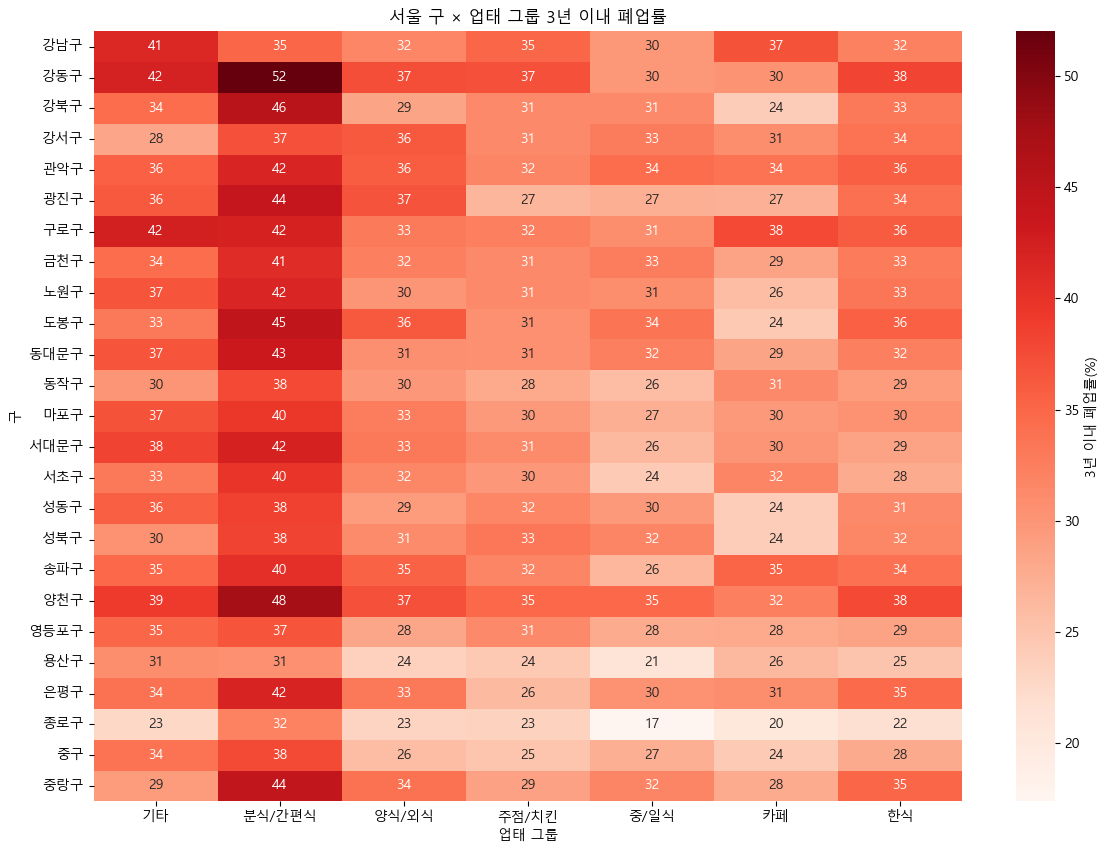

In [32]:
# ===============================
#  히트맵 시각화
# ===============================
plt.figure(figsize=(14,10))
sns.heatmap(
    pivot_gu_type_pct,
    cmap='Reds',
    annot=True,
    cbar_kws={'label': '3년 이내 폐업률(%)'}
)
plt.title('서울 구 × 업태 그룹 3년 이내 폐업률')
plt.xlabel('업태 그룹')
plt.ylabel('구')
plt.show()


In [33]:
# ===============================
#  위험 조합 TOP 추출
# ===============================
risk_table = pivot_gu_type_pct.stack().reset_index()
risk_table.columns = ['구', '업태_그룹', '폐업률']
risk_table.sort_values('폐업률', ascending=False).head(10)

,구,업태_그룹,폐업률
8,강동구,분식/간편식,52.0
127,양천구,분식/간편식,47.5
15,강북구,분식/간편식,45.5
64,도봉구,분식/간편식,44.7
169,중랑구,분식/간편식,44.5
36,광진구,분식/간편식,44.1
71,동대문구,분식/간편식,43.3
42,구로구,기타,42.5
7,강동구,기타,42.2
43,구로구,분식/간편식,42.1


In [35]:
gu_rate_map = (
    df.groupby('구')['폐업_3년이내']
      .mean()
      .mul(100)
      .round(1)
      .reset_index()
)

gu_rate_map.sort_values('폐업_3년이내', ascending=False).head()


,구,폐업_3년이내
1,강동구,39.3
18,양천구,37.9
6,구로구,35.9
4,관악구,35.7
9,도봉구,35.1


In [36]:
seoul_map = gpd.read_file(
    "https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json"
)

seoul_map.head()


,code,name,name_eng,base_year,geometry
0,11250,강동구,Gangdong-gu,2013,"POLYGON ((127.11520 37.55753, 127.11880 37.557..."
1,11240,송파구,Songpa-gu,2013,"POLYGON ((127.06907 37.52228, 127.07496 37.520..."
2,11230,강남구,Gangnam-gu,2013,"POLYGON ((127.05867 37.52630, 127.06907 37.522..."
3,11220,서초구,Seocho-gu,2013,"POLYGON ((127.01397 37.52504, 127.01918 37.520..."
4,11210,관악구,Gwanak-gu,2013,"POLYGON ((126.98368 37.47386, 126.98464 37.469..."


In [37]:
# 지도 쪽 구 이름 컬럼 통일
seoul_map['구'] = seoul_map['name']

# merge
map_df = seoul_map.merge(
    gu_rate_map,
    on='구',
    how='left'
)

map_df

,code,name,name_eng,base_year,geometry,구,폐업_3년이내
0,11250,강동구,Gangdong-gu,2013,"POLYGON ((127.11520 37.55753, 127.11880 37.557...",강동구,39.3
1,11240,송파구,Songpa-gu,2013,"POLYGON ((127.06907 37.52228, 127.07496 37.520...",송파구,34.2
2,11230,강남구,Gangnam-gu,2013,"POLYGON ((127.05867 37.52630, 127.06907 37.522...",강남구,33.2
3,11220,서초구,Seocho-gu,2013,"POLYGON ((127.01397 37.52504, 127.01918 37.520...",서초구,30.3
4,11210,관악구,Gwanak-gu,2013,"POLYGON ((126.98368 37.47386, 126.98464 37.469...",관악구,35.7
5,11200,동작구,Dongjak-gu,2013,"POLYGON ((126.98224 37.50931, 126.98242 37.501...",동작구,30.1
6,11190,영등포구,Yeongdeungpo-gu,2013,"POLYGON ((126.89185 37.54737, 126.90281 37.541...",영등포구,30.3
7,11180,금천구,Geumcheon-gu,2013,"POLYGON ((126.90156 37.47754, 126.90277 37.476...",금천구,33.2
8,11170,구로구,Guro-gu,2013,"POLYGON ((126.82688 37.50549, 126.83122 37.505...",구로구,35.9
9,11160,강서구,Gangseo-gu,2013,"POLYGON ((126.85984 37.57185, 126.85950 37.568...",강서구,33.4


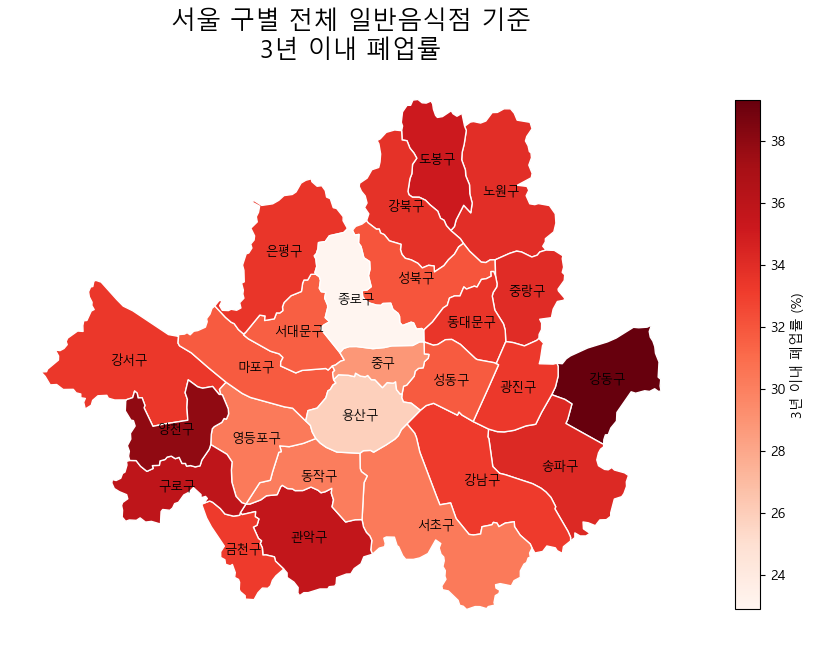

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(11, 11))

# 1️⃣ 지도 색칠
map_df.plot(
    column='폐업_3년이내',
    cmap='Reds',
    linewidth=1,
    ax=ax,
    edgecolor='white',
    legend=True,
    legend_kwds={
        'label': '3년 이내 폐업률 (%)',
        'shrink': 0.6
    }
)

# 2️⃣ 구 이름 표시 (centroid 사용)
for idx, row in map_df.iterrows():
    if row['geometry'] is not None:
        x = row['geometry'].centroid.x
        y = row['geometry'].centroid.y
        ax.text(
            x, y,
            row['구'],
            fontsize=9,
            ha='center',
            va='center',
            color='black'
        )

# 3️⃣ 제목
ax.set_title(
    '서울 구별 전체 일반음식점 기준\n3년 이내 폐업률',
    fontsize=18,
    pad=12
)

ax.axis('off')
plt.show()


In [39]:
df['생존_3년이상'] = (
    (df['폐업일자'].isna()) &
    (df['영업일수'] >= 365 * 3)
)
df['생존_3년이상'].value_counts()

False    206312
True      75272
Name: 생존_3년이상, dtype: int64

In [40]:
df['상태'] = '기타'

df.loc[df['폐업_3년이내'] == 1, '상태'] = '폐업(3년 이내)'
df.loc[df['생존_3년이상'] == True, '상태'] = '3년 이상 영업중'


In [41]:
gdf_points = gpd.GeoDataFrame(
    df[df['상태'].isin(['폐업(3년 이내)', '3년 이상 영업중'])],
    geometry=[
        Point(xy) for xy in zip(
            df.loc[df['상태'].isin(['폐업(3년 이내)', '3년 이상 영업중']), '좌표정보x(epsg5174)'],
            df.loc[df['상태'].isin(['폐업(3년 이내)', '3년 이상 영업중']), '좌표정보y(epsg5174)']
        )
    ],
    crs="EPSG:5174"
)


In [42]:

gdf_points = gpd.GeoDataFrame(
    df,
    geometry=[
        Point(xy) for xy in zip(
            df['좌표정보x(epsg5174)'],
            df['좌표정보y(epsg5174)']
        )
    ],
    crs="EPSG:5174"
)

gdf_points.head()


,인허가일자,상세영업상태명,폐업일자,소재지전체주소,도로명전체주소,사업장명,업태구분명,좌표정보x(epsg5174),좌표정보y(epsg5174),주소,...,창업연도,영업일수,폐업_3년이내,업태,업태_정리,업태_최종,업태_그룹,생존_3년이상,상태,geometry
17,2020-08-03,영업,NaT,서울특별시 강서구 화곡동 827-2 1층,"서울특별시 강서구 등촌로13다길 35, 1층 (화곡동)",꾸어가게생선구이화곡점,한식,187499.286366,448069.583478,서울특별시 강서구 화곡동 827-2 1층,...,2020,1971,0,한식,한식,한식,한식,True,3년 이상 영업중,POINT (187499.286 448069.583)
18,2020-08-03,영업,NaT,서울특별시 광진구 광장동 322-6,"서울특별시 광진구 아차산로76가길 5, 1층 (광장동)",37.5광진점,기타,209442.103893,449442.721078,서울특별시 광진구 광장동 322-6,...,2020,1971,0,기타,기타,기타,기타,True,3년 이상 영업중,POINT (209442.104 449442.721)
19,2020-08-03,영업,NaT,서울특별시 은평구 대조동 68-2,"서울특별시 은평구 역말로10길 32, 1층 우측호 (대조동)",베엔타,출장조리,193206.049815,456310.309764,서울특별시 은평구 대조동 68-2,...,2020,1971,0,출장조리,출장조리,출장조리,기타,True,3년 이상 영업중,POINT (193206.050 456310.310)
20,2020-08-03,영업,NaT,서울특별시 은평구 진관동 296-12,"서울특별시 은평구 북한산로 271-3, 2층 (진관동)","북한산큰숲,제빵소",한식,194550.757271,461372.337336,서울특별시 은평구 진관동 296-12,...,2020,1971,0,한식,한식,한식,한식,True,3년 이상 영업중,POINT (194550.757 461372.337)
21,2020-08-03,영업,NaT,서울특별시 강남구 신사동 613-5 캐럴라인타워,"서울특별시 강남구 압구정로32길 11, 캐럴라인타워 지상1층 107호 (신사동)",코이라멘 압구정점,일식,202601.216639,447186.659483,서울특별시 강남구 신사동 613-5 캐럴라인타워,...,2020,1971,0,일식,일식,일식,중/일식,True,3년 이상 영업중,POINT (202601.217 447186.659)


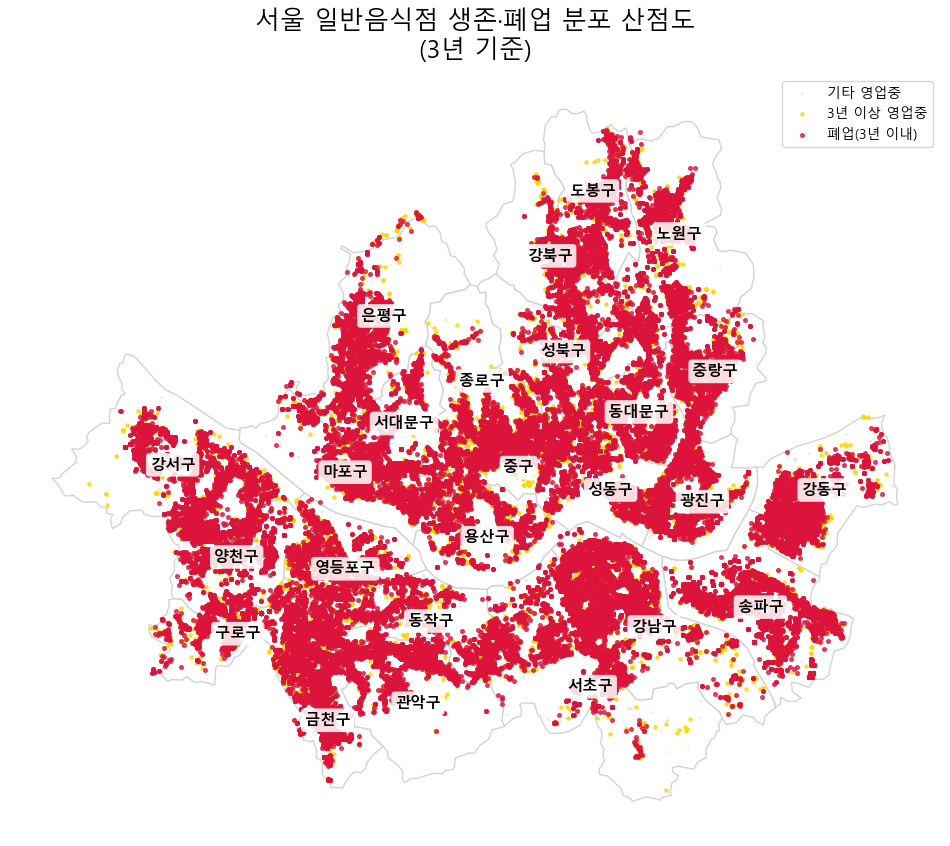

In [45]:
# 서울 지도 좌표계 변환
seoul_map_5174 = seoul_map.to_crs(epsg=5174)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# 1️⃣ 배경 지도
seoul_map_5174.plot(
    ax=ax,
    color='white',
    edgecolor='lightgray',
    linewidth=1
)

# 2️⃣ 기타 영업중 (배경)
gdf_points[gdf_points['상태'] == '기타'].plot(
    ax=ax,
    markersize=2,
    color='lightgray',
    alpha=0.2,
    label='기타 영업중'
)

# 3️⃣ 🟡 3년 이상 영업중 (생존)
gdf_points[gdf_points['상태'] == '3년 이상 영업중'].plot(
    ax=ax,
    markersize=5,
    color='gold',
    alpha=0.8,
    label='3년 이상 영업중'
)

# 4️⃣ 🔴 폐업 (3년 이내)
gdf_points[gdf_points['상태'] == '폐업(3년 이내)'].plot(
    ax=ax,
    markersize=7,
    color='crimson',
    alpha=0.75,
    label='폐업(3년 이내)'
)

# 5️⃣ 구 이름 표시 (centroid)
for idx, row in seoul_map_5174.iterrows():
    x = row.geometry.centroid.x
    y = row.geometry.centroid.y
    ax.text(
        x, y,
        row['구'],
        fontsize=11,              # 글자 키움
        fontweight='bold',        # 굵게
        ha='center',
        va='center',
        color='black',
        bbox=dict(                # ⭐ 핵심
            boxstyle='round,pad=0.25',
            facecolor='white',
            edgecolor='none',
            alpha=0.85
        )
    )

# 6️⃣ 제목
ax.set_title(
    '서울 일반음식점 생존·폐업 분포 산점도\n(3년 기준)',
    fontsize=18,
    pad=12
)

ax.legend()
ax.axis('off')
plt.show()


In [46]:
category_colors = {
    '한식': '#e41a1c',
    '분식/간편식': '#377eb8',
    '양식/외식': '#4daf4a',
    '중·일식': '#984ea3',
    '주점/치킨': '#ff7f00',
    '카페': '#a65628',
    '기타': '#999999'
}


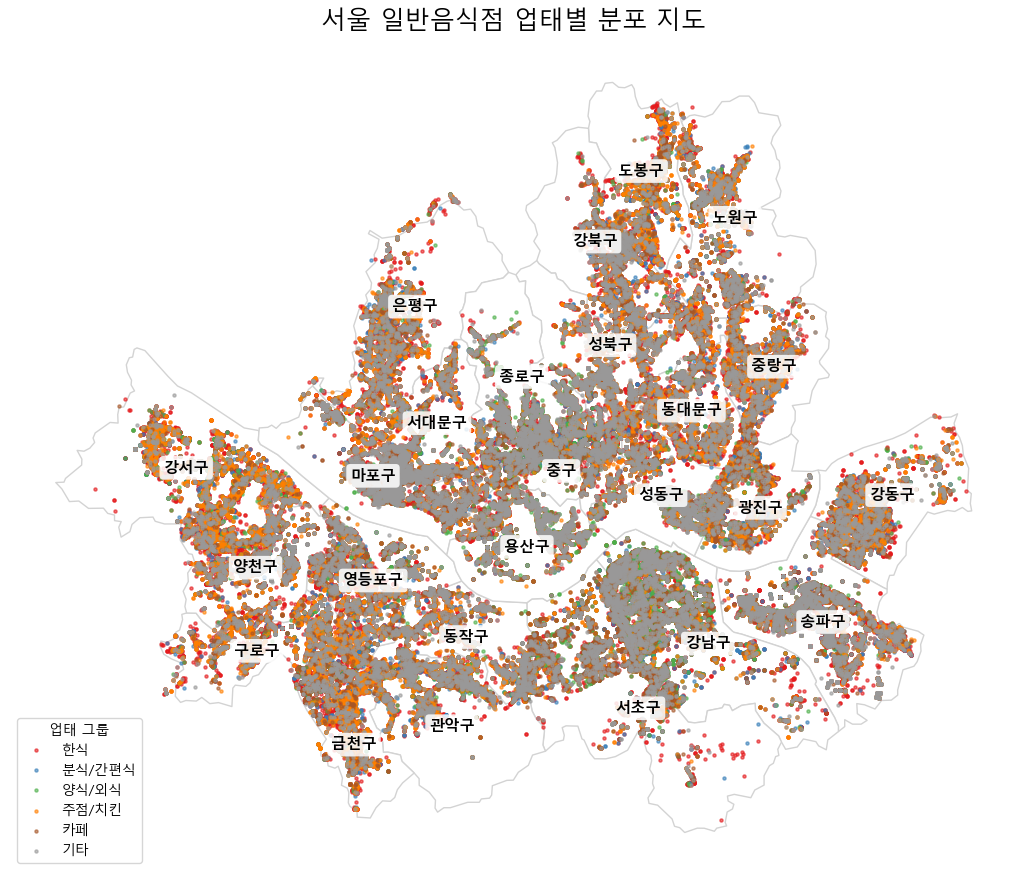

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(13, 13))

# 1️⃣ 배경 지도
seoul_map_5174.plot(
    ax=ax,
    color='white',
    edgecolor='lightgray',
    linewidth=1
)

# 2️⃣ 업태별 포인트 찍기
for category, color in category_colors.items():
    subset = gdf_points[gdf_points['업태_그룹'] == category]
    if len(subset) == 0:
        continue

    subset.plot(
        ax=ax,
        markersize=5,
        color=color,
        alpha=0.6,
        label=category
    )

# 3️⃣ 구 이름 표시
for _, row in seoul_map_5174.iterrows():
    x = row.geometry.centroid.x
    y = row.geometry.centroid.y
    ax.text(
        x, y,
        row['구'],
        fontsize=11,
        fontweight='bold',
        ha='center',
        va='center',
        bbox=dict(
            boxstyle='round,pad=0.25',
            facecolor='white',
            alpha=0.85,
            edgecolor='none'
        )
    )

# 4️⃣ 제목 & 옵션
ax.set_title(
    '서울 일반음식점 업태별 분포 지도',
    fontsize=18,
    pad=12
)
ax.legend(title='업태 그룹', loc='lower left')
ax.axis('off')

plt.show()


In [62]:
out = (
    df.groupby(["구", "업태_그룹"])["폐업_3년이내"]
      .agg(
          표본수="count",
          폐업률_3년이내_pct=lambda s: round(s.mean() * 100, 1)  # ✅ 소수점 1자리
      )
      .reset_index()
)

print(out.head(30))

print("\n[폐업률 높은 순 TOP 30]")
print(out.sort_values("폐업률_3년이내_pct", ascending=False).head(30))

      구   업태_그룹   표본수  폐업률_3년이내_pct
0   강남구      기타  1236          38.3
1   강남구  분식/간편식  3401          34.0
2   강남구   양식/외식  6044          30.3
3   강남구   주점/치킨  1227          33.3
4   강남구    중/일식  2172          28.1
5   강남구      카페   926          36.4
6   강남구      한식  8724          30.1
7   강동구      기타   550          39.3
8   강동구  분식/간편식  1533          52.3
9   강동구   양식/외식   376          36.4
10  강동구   주점/치킨  2261          36.8
11  강동구    중/일식   572          27.1
12  강동구      카페   363          29.5
13  강동구      한식  4790          37.3
14  강북구      기타   533          29.5
15  강북구  분식/간편식   983          45.6
16  강북구   양식/외식   188          26.6
17  강북구   주점/치킨  1662          30.6
18  강북구    중/일식   360          30.0
19  강북구      카페   421          21.4
20  강북구      한식  3516          32.3
21  강서구      기타   297          28.6
22  강서구  분식/간편식   962          36.3
23  강서구   양식/외식   785          33.1
24  강서구   주점/치킨  2498          30.8
25  강서구    중/일식   784          29.8
26  강서구      카페   121       

In [63]:
# 1) 구×업태_그룹 폐업률(%) 요약 테이블 만들기
rate = (
    df.groupby(["구", "업태_그룹"])["폐업_3년이내"]
      .agg(
          표본수="count",
          폐업률_3년이내_pct=lambda s: round(s.mean() * 100, 1)
      )
      .reset_index()
)

# 2) 원본 df에 머지해서 컬럼 추가
df_merged = df.merge(rate, on=["구", "업태_그룹"], how="left")

# 3) 확인 출력
print(df_merged[["구","업태_그룹","폐업_3년이내","표본수","폐업률_3년이내_pct"]])

# 4) 저장(선택)
df_merged.to_csv(r"C:\ai\lecNote\1st_Project\data\서울_일반음식점_전처리_폐업률머지.csv", index=False, encoding="utf-8-sig")

          구   업태_그룹  폐업_3년이내   표본수  폐업률_3년이내_pct
0       은평구      기타        0   490          31.0
1       은평구      한식        0  3670          33.2
2       서초구  분식/간편식        0  1406          39.7
3       서초구   양식/외식        0  1462          30.0
4        중구   주점/치킨        0   744          24.5
...     ...     ...      ...   ...           ...
241262  도봉구   주점/치킨        0  1337          30.4
241263  강동구      카페        0   363          29.5
241264  강남구      기타        0  1236          38.3
241265  송파구   주점/치킨        0  1812          31.3
241266  서초구   주점/치킨        0  1371          28.6

[241267 rows x 5 columns]
